In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight') # estilo dos gráficos

import warnings # retirar avisos
warnings.filterwarnings('ignore')

c:\Users\user\anaconda3\envs\electricity_demand\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\user\anaconda3\envs\electricity_demand\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\Users\user\anaconda3\envs\electricity_demand\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
path = "../data/daily_load.csv"
df_load = pd.read_csv(path, parse_dates = ["date"])
df_load_sul = df_load[df_load["id_reg"] == "S"]

df_load_sul["load_mwmed"].interpolate(inplace = True)

df_load_sul = df_load_sul[["date", "load_mwmed"]].set_index("date")

In [4]:
# Série em logaritmo
df_load_log = np.log(df_load_sul)

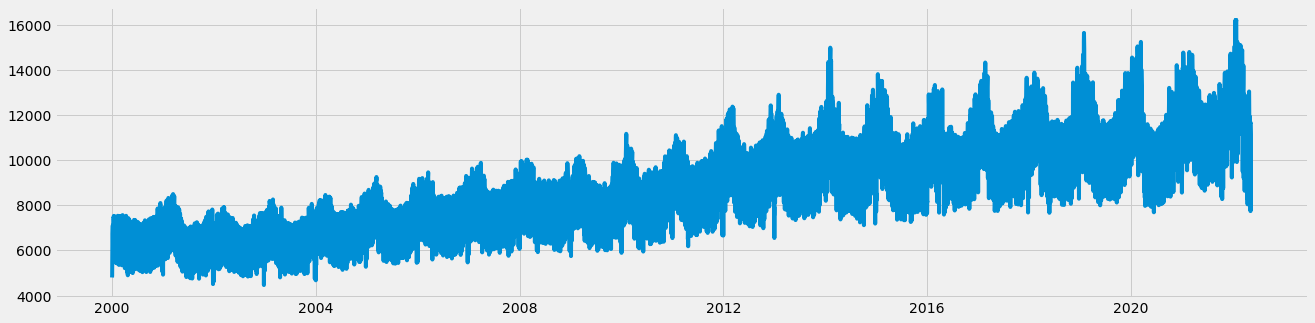

In [5]:
plt.figure(figsize = (20,5))

plt.plot(df_load_sul)
plt.show()

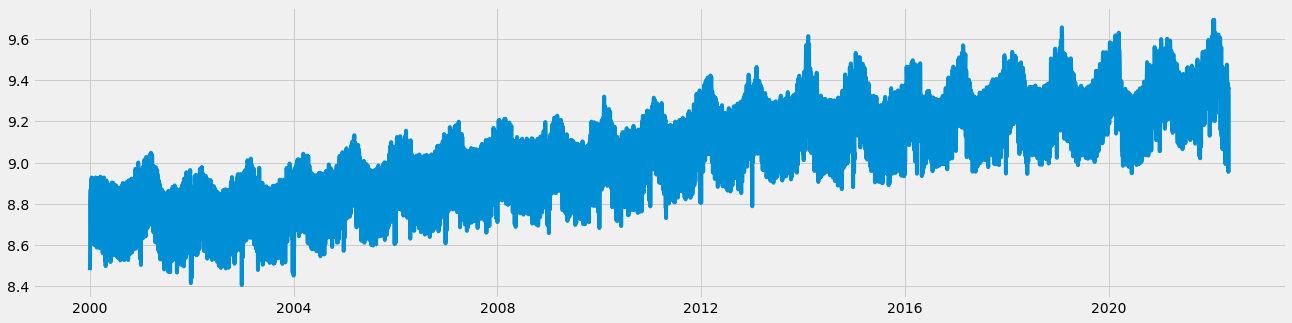

In [6]:
plt.figure(figsize = (20,5))

plt.plot(df_load_log)
plt.show()

## MODELAGEM

### Partição de treino e teste

In [7]:
train, test = df_load_sul.iloc[:-30], df_load_sul.iloc[-30:] 
train.tail(), train.head()

(              load_mwmed
 date                    
 2022-04-07  12512.483583
 2022-04-08  12271.662917
 2022-04-09  10395.100000
 2022-04-10   9137.307083
 2022-04-11  11983.965833,
              load_mwmed
 date                   
 2000-01-01  4800.650000
 2000-01-02  4899.800000
 2000-01-03  6261.554167
 2000-01-04  6733.741667
 2000-01-05  6961.170833)

In [8]:
# Série em logaritmo
train_log, test_log = df_load_log.iloc[:-30], df_load_log.iloc[-30:] 
train_log.tail(), train_log.head()

(            load_mwmed
 date                  
 2022-04-07    9.434482
 2022-04-08    9.415048
 2022-04-09    9.249090
 2022-04-10    9.120121
 2022-04-11    9.391325,
             load_mwmed
 date                  
 2000-01-01    8.476507
 2000-01-02    8.496950
 2000-01-03    8.742184
 2000-01-04    8.814886
 2000-01-05    8.848103)

### Identificação: FAC e FACP

In [9]:
# Pacotes para gráficos de autocorrelação e autocorrelação parcial
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

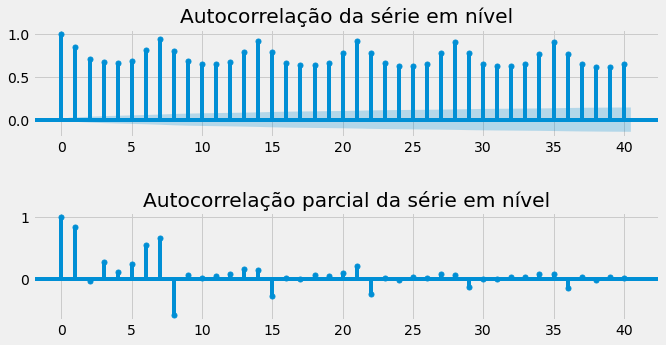

In [10]:
N, M = 10, 5

fig, (ax1, ax2) = plt.subplots(2, figsize = (N,M))
plot_acf(train["load_mwmed"], title = "Autocorrelação da série em nível", ax = ax1)
plot_pacf(train["load_mwmed"], title = "Autocorrelação parcial da série em nível", ax = ax2)

plt.subplots_adjust(hspace= 0.7)
plt.show()

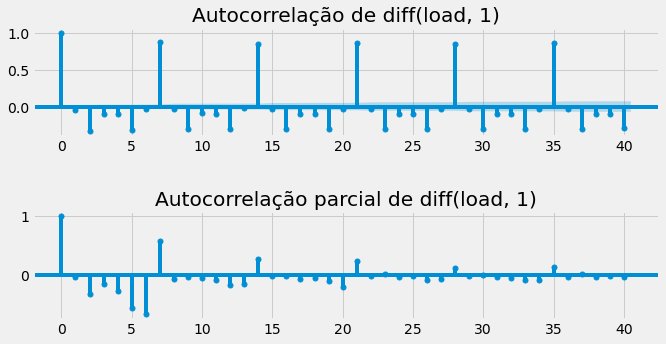

In [11]:
df_load_sul_diff1 = train["load_mwmed"].diff().dropna()

fig, (ax1, ax2) = plt.subplots(2, figsize = (N,M))
plot_acf(df_load_sul_diff1, title = "Autocorrelação de diff(load, 1)", ax = ax1)
plot_pacf(df_load_sul_diff1, title = "Autocorrelação parcial de diff(load, 1)", ax = ax2)

plt.subplots_adjust(hspace= 0.7)
plt.show()

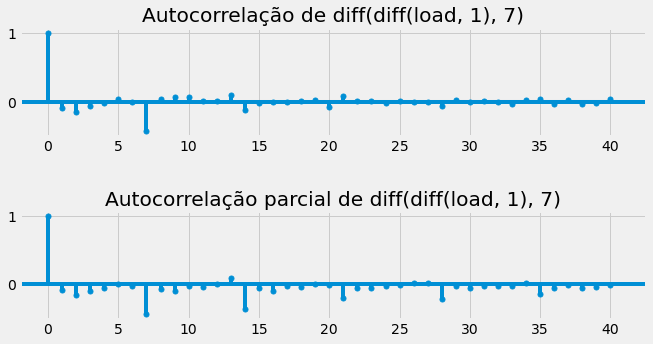

In [12]:
df_load_sul_diff1_diff7 = df_load_sul_diff1.diff(7).dropna()

fig, (ax1, ax2) = plt.subplots(2, figsize = (N,M))
plot_acf(df_load_sul_diff1_diff7, title = "Autocorrelação de diff(diff(load, 1), 7)", ax = ax1)
plot_pacf(df_load_sul_diff1_diff7, title = "Autocorrelação parcial de diff(diff(load, 1), 7)", ax = ax2)

plt.subplots_adjust(hspace= 0.7)
plt.show()

### Estimação

In [13]:
# Pacote para SARIMAX
import statsmodels.api as sm

In [14]:
# MODELOS

model1 = sm.tsa.statespace.SARIMAX(train,order=(1, 1, 1),seasonal_order=(1,1,1,7))
results1 = model1.fit()

model2 = sm.tsa.statespace.SARIMAX(train,order=(4, 1, 5),seasonal_order=(1,1,1,7))
results2 = model2.fit()

c:\Users\user\anaconda3\envs\electricity_demand\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\user\anaconda3\envs\electricity_demand\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\user\anaconda3\envs\electricity_demand\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\user\anaconda3\envs\electricity_demand\lib\site-packages\statsmodel

In [15]:
# FORECASTS

fc1 = results1.forecast(30)
fc1.index = test.index

fc2 = results2.forecast(30)
fc2.index = test.index

c:\Users\user\anaconda3\envs\electricity_demand\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
c:\Users\user\anaconda3\envs\electricity_demand\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


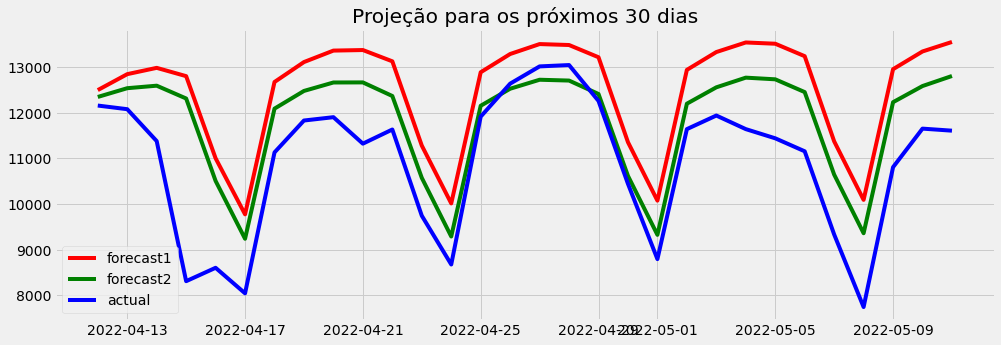

In [16]:
plt.figure(figsize = (15, 5))

plt.plot(fc1, c = "red", label = "forecast1")
plt.plot(fc2, c = "green", label = "forecast2")
plt.plot(test, c = "blue", label = "actual")

plt.title("Projeção para os próximos 30 dias")
plt.legend()

plt.show()

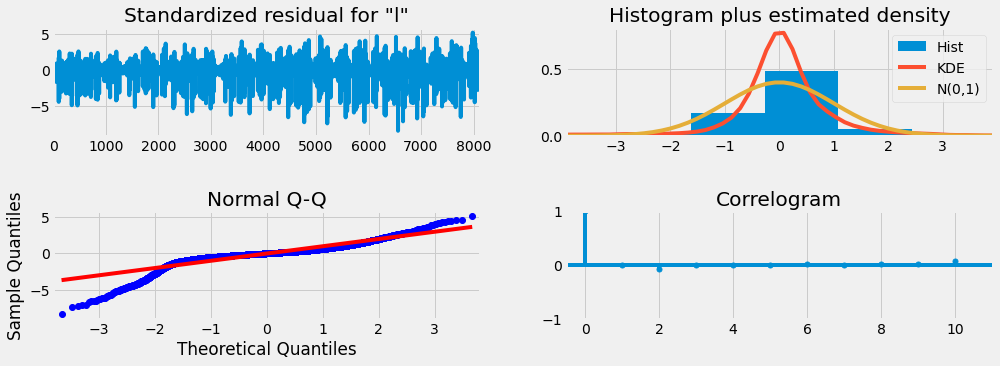

In [17]:
# FORECAST 1
results1.plot_diagnostics(figsize=(15,5))

plt.subplots_adjust(hspace= 0.7)
plt.show()

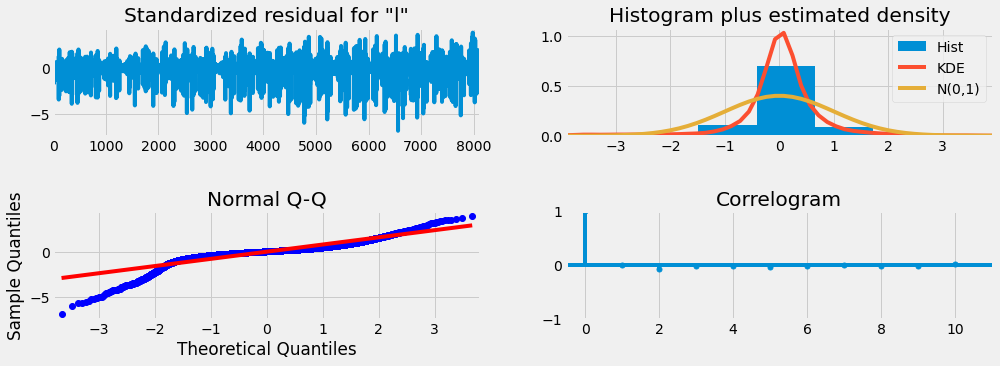

In [18]:
# FORECAST 2
results2.plot_diagnostics(figsize=(15,5))

plt.subplots_adjust(hspace= 0.7)
plt.show()

### Acurácia

In [19]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from math import sqrt

def get_measures(forecast, test):
    errors = [(test.iloc[i][0] - forecast.iloc[i])**2 for i in range(len(test))]
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = sqrt(mse)
    mape = np.mean(np.abs((test.values - forecast.values)/test.values))*100

    a = np.reshape(test.values, (-1,))
    b = np.reshape(forecast.values, (-1,))
    smape = np.mean(100*2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()

    measures = { "erro": sum(errors),
                 "mae": mae,
                 "mse": mse,
                 "rmse": rmse,
                 "mape": mape,
                 "smape": smape
                }
    
    # arredondamento
    for key, item in measures.items():
        measures[key] = round(measures[key], 2)
    
    return measures

In [20]:
medidas_fc1 = get_measures(fc1, test)
medidas_fc2 = get_measures(fc2, test)

print("fc1:", medidas_fc1)
print("fc2:", medidas_fc2)

fc1: {'erro': 91016128.14, 'mae': 1555.81, 'mse': 3033870.94, 'rmse': 1741.8, 'mape': 20.62, 'smape': 13.79}
fc2: {'erro': 42749164.54, 'mae': 936.04, 'mse': 1424972.15, 'rmse': 1193.72, 'mape': 16.96, 'smape': 8.64}


In [21]:
print("Erros quadráticos forecast1:", medidas_fc1["erro"], " AIC:", round(results1.aic, 2), " BIC:", round(results1.bic, 2))
print("Erros quadráticos forecast2:", medidas_fc2["erro"], " AIC:", round(results2.aic, 2), " BIC:", round(results2.bic, 2))

Erros quadráticos forecast1: 91016128.14  AIC: 121972.12  BIC: 122007.14
Erros quadráticos forecast2: 42749164.54  AIC: 122769.1  BIC: 122853.14


### AUTO ARIMA

In [22]:
import pmdarima as pm

In [97]:
SARIMA_model = pm.auto_arima(train, 
                            start_p=1, 
                            start_q=1,
                            test='kpss', # use adftest to find optimal 'd'
                            max_p=4, max_q=5, # maximum p and q
                            max_P=1, max_Q=1,
                            m=7, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                            #d=None,
                            max_d = 2,
                            #D=None# let model determine 'd'
                            max_D = 1,
                            seasonal=True, # No Seasonality for standard ARIMA
                            trace=True, #logs 
                            error_action='warn', #shows errors ('ignore' silences these)
                            suppress_warnings=True,
                            stepwise=True,
                            information_criterion='bic')

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : BIC=inf, Time=17.30 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : BIC=138187.102, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : BIC=126459.075, Time=2.34 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : BIC=132682.174, Time=2.43 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=138178.102, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : BIC=138180.209, Time=0.19 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : BIC=123129.098, Time=6.11 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : BIC=132704.489, Time=2.49 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : BIC=123196.215, Time=4.22 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : BIC=122853.132, Time=7.68 sec
 ARIMA(2,1,0)(0,0,1)[7] intercept   : BIC=132046.060, Time=3.12 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : BIC=126252.653, Time=4.91 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : BIC=137248.690, Time=0.39 sec
 ARIMA(3,1,0)(1,0,1)[7] intercept   : BIC=122755.295, Time=14.72 sec
 ARIMA(3,1

In [23]:
# Série em logaritmo
SARIMA_log_model = pm.auto_arima(train_log, 
                            start_p=1, 
                            start_q=1,
                            test='kpss', # use adftest to find optimal 'd'
                            max_p=4, max_q=5, # maximum p and q
                            max_P=1, max_Q=1,
                            m=7, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                            #d=None,
                            max_d = 2,
                            #D=None# let model determine 'd'
                            max_D = 1,
                            seasonal=True, # No Seasonality for standard ARIMA
                            trace=True, #logs 
                            error_action='warn', #shows errors ('ignore' silences these)
                            suppress_warnings=True,
                            stepwise=True,
                            information_criterion='bic')

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : BIC=-25186.948, Time=9.02 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : BIC=-9017.029, Time=0.36 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : BIC=-21547.215, Time=1.97 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : BIC=-14971.984, Time=2.45 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=-9026.028, Time=0.15 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : BIC=-17004.885, Time=7.76 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : BIC=-22951.309, Time=6.27 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : BIC=-11707.451, Time=3.09 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : BIC=-24958.428, Time=7.50 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : BIC=-24801.771, Time=6.33 sec
 ARIMA(2,1,1)(1,0,1)[7] intercept   : BIC=-24971.941, Time=9.56 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : BIC=-25188.734, Time=10.16 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept   : BIC=-17327.978, Time=9.35 sec
 ARIMA(1,1,2)(1,0,0)[7] intercept   : BIC=-22838.106, Time=8.00 sec
 ARIMA

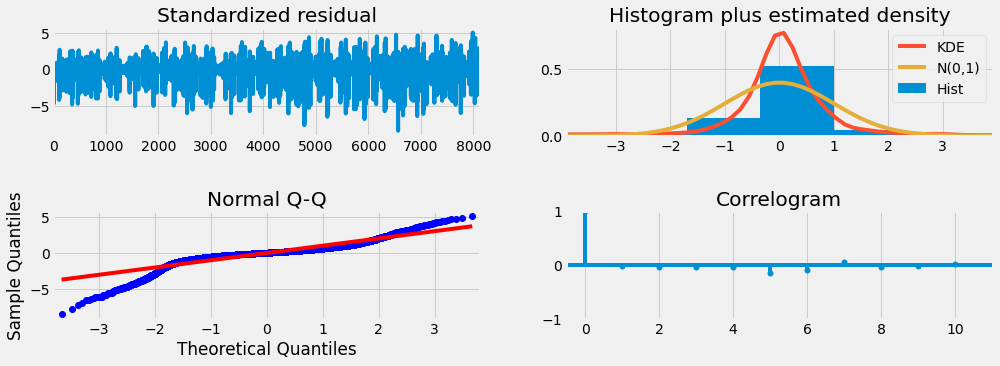

In [109]:
# Best model:  ARIMA(4,1,0)(1,0,1)[7]
SARIMA_model.plot_diagnostics(figsize=(15,5))

plt.subplots_adjust(hspace= 0.7)
plt.show()

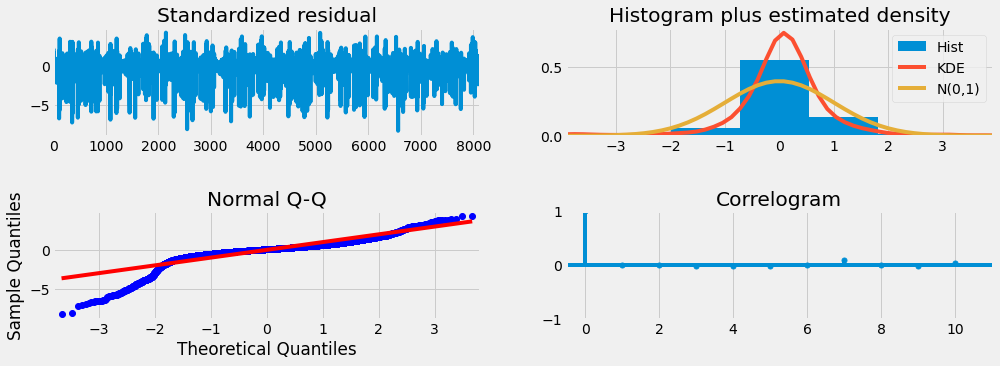

In [24]:
SARIMA_log_model.plot_diagnostics(figsize=(15,5))

plt.subplots_adjust(hspace= 0.7)
plt.show()

In [30]:
#fc3 = pd.Series(SARIMA_model.predict(n_periods= 30))
model3 = sm.tsa.statespace.SARIMAX(train,order=(4, 1, 0),seasonal_order=(1,0,1,7))
results3 = model3.fit()
fc3 = results3.forecast(30)
fc3.index = test.index

c:\Users\user\anaconda3\envs\electricity_demand\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\user\anaconda3\envs\electricity_demand\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\Users\user\anaconda3\envs\electricity_demand\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [31]:
fc4 = pd.Series(SARIMA_log_model.predict(n_periods= 30))
fc4.index = test.index
fc4_exp = np.exp(fc4)

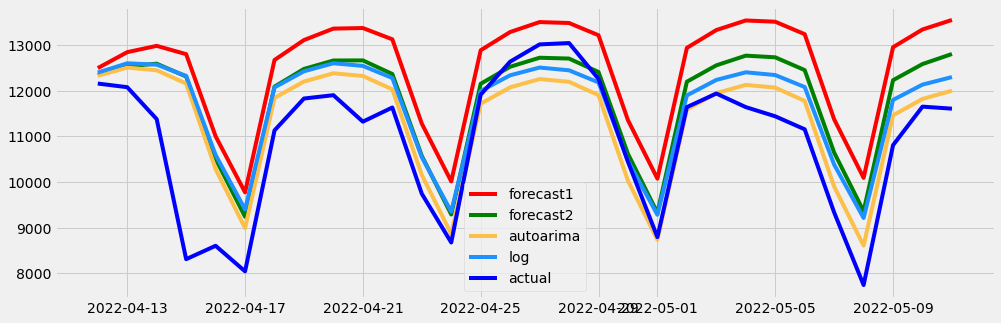

In [32]:
plt.figure(figsize = (15, 5))

plt.plot(fc1, c = "red", label = "forecast1")
plt.plot(fc2, c = "green", label = "forecast2")
plt.plot(fc3, c = "#fcbf49", label = "autoarima")
plt.plot(fc4_exp, c = "dodgerblue", label = "autoarima_log")
plt.plot(test, c = "blue", label = "actual")

plt.legend()

plt.show()

In [35]:
medidas_fc1 = get_measures(fc1, test)
medidas_fc2 = get_measures(fc2, test)
medidas_fc3 = get_measures(fc3, test)
medidas_fc4 = get_measures(fc4_exp, test)

print("fc1:", medidas_fc1)
print("fc2:", medidas_fc2)
print("fc3:", medidas_fc3)
print("fc4:", medidas_fc4)

fc1: {'erro': 91016128.14, 'mae': 1555.81, 'mse': 3033870.94, 'rmse': 1741.8, 'mape': 20.62, 'smape': 13.79}
fc2: {'erro': 42749164.54, 'mae': 936.04, 'mse': 1424972.15, 'rmse': 1193.72, 'mape': 16.96, 'smape': 8.64}
fc3: {'erro': 26810782.15, 'mae': 645.3, 'mse': 893692.74, 'rmse': 945.35, 'mape': 15.24, 'smape': 6.03}
fc4: {'erro': 36782026.61, 'mae': 827.3, 'mse': 1226067.55, 'rmse': 1107.28, 'mape': 15.89, 'smape': 7.75}


In [124]:
print("Erros quadráticos forecast1:", medidas_fc1["erro"], " AIC:", round(results1.aic, 2), " BIC:", round(results1.bic, 2))
print("Erros quadráticos forecast2:", medidas_fc2["erro"], " AIC:", round(results2.aic, 2), " BIC:", round(results2.bic, 2))
print("Erros quadráticos forecast3:", medidas_fc3["erro"], " AIC:", round(SARIMA_model.aic(), 2), " BIC:", round(SARIMA_model.bic(), 2))

Erros quadráticos forecast1: 91014589.44  AIC: 121972.12  BIC: 122007.14
Erros quadráticos forecast2: 31495775.14  AIC: 122688.16  BIC: 122772.2
Erros quadráticos forecast3: 26814967.28  AIC: 122581.68  BIC: 122630.71
